In [136]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, MaxPooling1D, MaxPooling2D, Conv2D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from scipy.stats import kurtosis, skew
from sklearn.metrics import confusion_matrix
from seaborn import heatmap


In [137]:
def disp2vel(disp,dt):
    vel = np.zeros(disp.shape)
    vel[:,1:] = (disp[:,1:]-disp[:,0:-1])/dt
    vel[:,0] = -2*vel[:,0]+vel[:,1]
    return vel

def vel2acc(vel,dt):
    acc = np.zeros(vel.shape)
    acc[:,1:] = (vel[:,1:]-vel[:,0:-1])/dt
    acc[:,0] = -2*acc[:,0]+acc[:,1]
    return acc

def acc2vel(acc,dt):
    vel = np.zeros(acc.shape)
    for i in range(0,vel.shape[1]-1):
        vel[:,i+1] = vel[:,i]+1/2*(acc[:,i+1]+acc[:,i])*dt
    print(i)
    return vel

def vel2disp(vel,dt):
    disp = np.zeros(vel.shape)
    for i in range(1,disp.shape[1]-1):
        disp[:,i+1] = disp[:,i]+1/2*(vel[:,i+1]+vel[:,i])*dt
    return disp

In [138]:
mat = scipy.io.loadmat('test2010.mat')

In [139]:
chan_names = mat['chan_names']
data = mat['data']

In [140]:
D = 0.027

t1 = 15
t2 = 165
Fs = 1200
dt = 1/Fs
tst = t1*Fs
ted = t2*Fs

nm = data.shape[1]
time = np.arange(0,nm-1)*dt
time = time[tst:ted].reshape(1,-1)

strain_CF = data[46:70,tst:ted]
strain_IL = data[6:46,tst:ted]
pos_IL = data[98:106,tst:ted]
pos_CF = data[106:114,tst:ted]
acc_IL = data[70:78,tst:ted]
acc_CF = data[78:86,tst:ted]

# Strain sensor positions
str_il = np.array([1.143,2.555,3.084,3.224,4.155,5.759,6.030,7.664,8.216,8.609,8.889,9.703,10.285,13.676,13.772,
                     15.393,16.452,16.547,16.891,19.997,20.193,21.393,21.603,22.460,23.165,25.153,25.442,26.254,27.532,
                     28.698,28.863,29.365,31.191,31.415,32.796,33.005,35.549,36.559,36.824,37.322])
str_sensor_cf = np.array([2,3,4,5,7,10,11,13,14,17,19,20,21,22,24,25,26,28,31,32,33,36,38,40])-1
str_cf = str_il[str_sensor_cf]

# Accelerometer positions
acc_pos = np.array([4.155,8.609,13.676,16.891,21.393,25.153,28.863,33.005])

# Finding indices for strain locations which will be fused 
sensor_diff_il = np.abs(np.tile(str_il,(8,1)).T - acc_pos)
sensor_transform_index_il = np.argmin(sensor_diff_il,axis=1)

sensor_diff_cf = np.abs(np.tile(str_cf,(8,1)).T - acc_pos)
sensor_transform_index_cf = np.argmin(sensor_diff_cf,axis=1)

max_strain_CF = strain_CF.argmax(axis=0)
max_strain_CF_loc = str_cf[max_strain_CF]

In [147]:
#X = np.vstack((time,pos_IL,pos_CF,vel_IL,vel_CF,acc_IL,acc_CF)).transpose()
X = np.vstack((time,acc_IL,acc_CF)).transpose()
#Y = np.vstack((strain_CF.argmax(axis=0),strain_IL.argmax(axis=0))).transpose()
Y = np.vstack(max_strain_CF_loc).transpose()
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
#Y = (Y-Y.min())/(Y.max()-Y.min())

n_features = X.shape[1]
b_size = 100
n_outputs = Y.shape[0]

n_batches = int(X.shape[0]/b_size)
X = X.reshape(n_batches,b_size,n_features)
Y = Y.reshape(n_batches,b_size,n_outputs)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42,shuffle=False)

t_train = X_train[:,:,0]
t_test = X_test[:,:,0]
X_train = X_train[:,:,0:-1]
X_test = X_test[:,:,0:-1]

n_features = n_features-1
n_outputs = Y.max()+1

In [152]:
X.shape

(1800, 100, 17)

In [116]:
# Classification
#model = Sequential(name='LSTM')
#model.add(LSTM(
 #   units=100,
  #  batch_input_shape=(None,X.shape[1],n_features),
   # return_sequences=True,
    #dropout=0,
    #recurrent_dropout=0))
#model.add(LSTM(
 #   units=100,
  #  batch_input_shape=(None,X.shape[1],n_features),
   # return_sequences=True,
    #dropout=0.1,
    #recurrent_dropout=0))
#model.add(Dense(50,activation='relu'))
#model.add(Dropout(0))
#model.add(Dense(n_outputs, activation='softmax'))
#model.add(MaxPooling1D(pool_size=1))

#model.summary()
#model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['SparseCategoricalAccuracy'])

In [165]:
# Regression
model = Sequential(name='LSTM')
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0,
    recurrent_dropout=0))
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0,
    recurrent_dropout=0))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0))
model.add(Dense(1, activation='relu'))

model.summary()
model.compile(optimizer="Adam", loss="MeanSquaredError")

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100, 100)          46800     
_________________________________________________________________
lstm_26 (LSTM)               (None, 100, 100)          80400     
_________________________________________________________________
dense_30 (Dense)             (None, 100, 50)           5050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
dense_31 (Dense)             (None, 100, 1)            51        
Total params: 132,301
Trainable params: 132,301
Non-trainable params: 0
_________________________________________________________________


In [166]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback)

Epoch 1/100
38/38 [==============================] - 5s 60ms/step - loss: 241.2291
Epoch 2/100
38/38 [==============================] - 2s 61ms/step - loss: 110.6533
Epoch 3/100
38/38 [==============================] - 4s 98ms/step - loss: 102.8354
Epoch 4/100
38/38 [==============================] - 4s 109ms/step - loss: 93.5129
Epoch 5/100
38/38 [==============================] - 4s 109ms/step - loss: 86.8109
Epoch 6/100
38/38 [==============================] - 4s 110ms/step - loss: 85.3138
Epoch 7/100
38/38 [==============================] - 4s 115ms/step - loss: 80.5607
Epoch 8/100
38/38 [==============================] - 4s 115ms/step - loss: 77.4554
Epoch 9/100
38/38 [==============================] - 4s 106ms/step - loss: 74.9391
Epoch 10/100
38/38 [==============================] - 4s 109ms/step - loss: 72.6019
Epoch 11/100
38/38 [==============================] - 4s 108ms/step - loss: 72.30130s
Epoch 12/100
38/38 [==============================] - 4s 107ms/step - loss: 70.4523

In [167]:
y_pred = model.predict(X_test)

In [168]:
y_test.shape

(594, 100, 1)

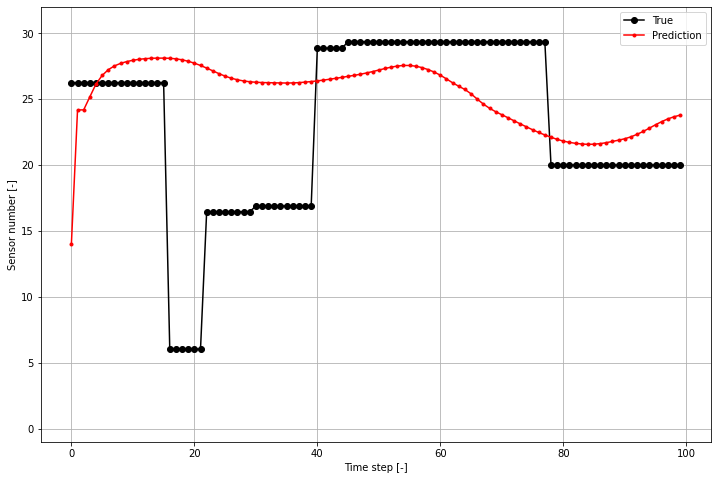

In [169]:
n = 3
plt.figure(figsize=(12,8))
plt.plot(y_test[n,:],'ko-',label='True')
plt.plot(y_pred[n,:],'r.-',label='Prediction')

plt.legend()
plt.grid()
plt.ylim([-1,32])
plt.ylabel('Sensor number [-]')
plt.xlabel('Time step [-]')
plt.show()

In [100]:
from sklearn.metrics import confusion_matrix

y_p = y_pred.reshape(-1,1)
y_true = y_test.reshape(-1,1)

cm = confusion_matrix(y_true,y_p)
misclassification_rate = 1-np.diagonal(cm).sum()/y_true.shape[0]
print(misclassification_rate)

from seaborn import heatmap

plt.figure(figsize=(12,12))
plt.imshow(cm)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [59400, 1425600]

In [16]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model,X_test,y_pred)

ValueError: plot_confusion_matrix only supports classifiers

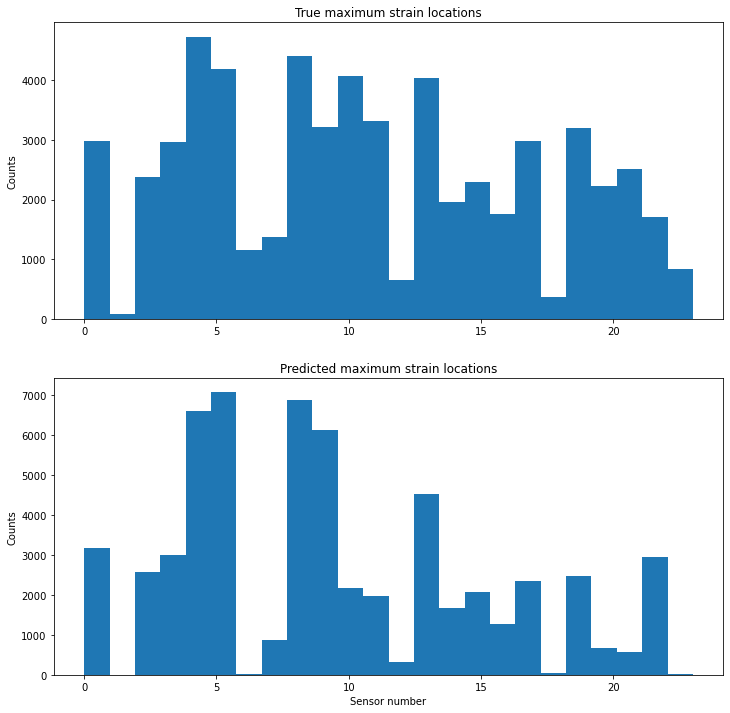

In [15]:
fig, ax = plt.subplots(2,figsize=(12,12))
ax[0].hist(y_true,bins=24)
ax[1].hist(y_p,bins=24)
ax[1].set_xlabel('Sensor number')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[0].set_title('True maximum strain locations')
ax[1].set_title('Predicted maximum strain locations')
plt.show()